Suspicious transactions detected: 3


C:\Users\sinha\AppData\Local\Temp\ipykernel_23568\1213543917.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_check['amount_range'] = pd.cut(fraud_check['Amount (INR)'], bins=bins, labels=labels, include_lowest=True)
C:\Users\sinha\AppData\Local\Temp\ipykernel_23568\1213543917.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='amount_range', y='Amount (INR)', data=fraud_check, estimator=sum, ci=None, palette='mako')
C:\Users\sinha\AppData\Local\Temp\ipykernel_23568\1213543917.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.bar

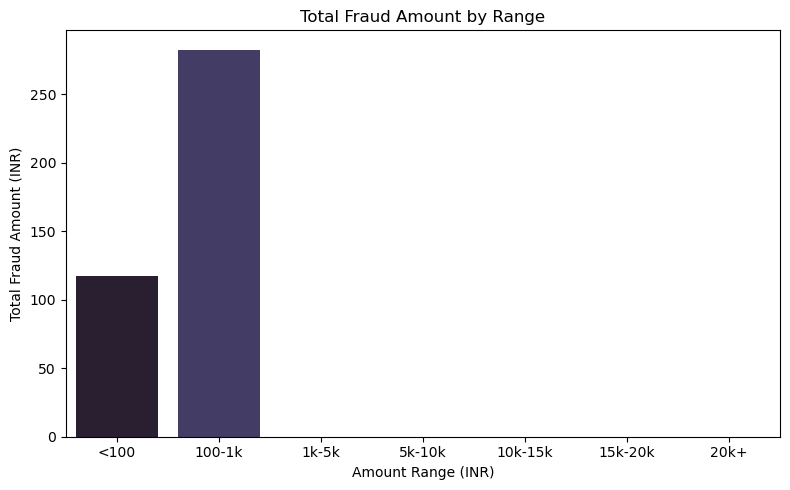

C:\Users\sinha\AppData\Local\Temp\ipykernel_23568\1213543917.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_check['sender_bank'] = fraud_check['Sender UPI ID'].apply(extract_bank)


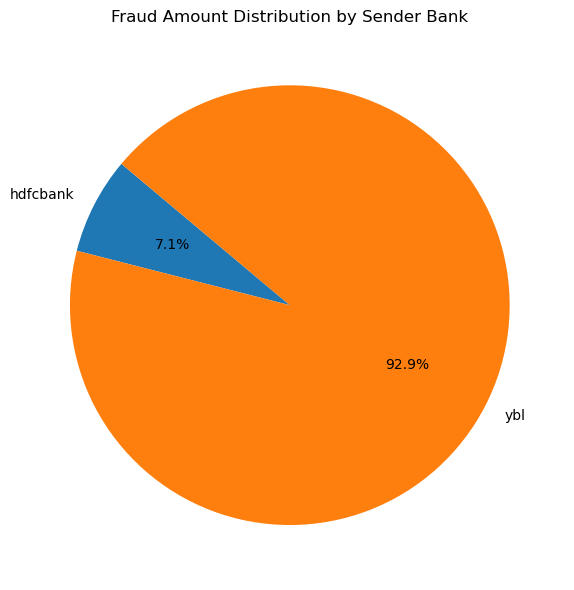

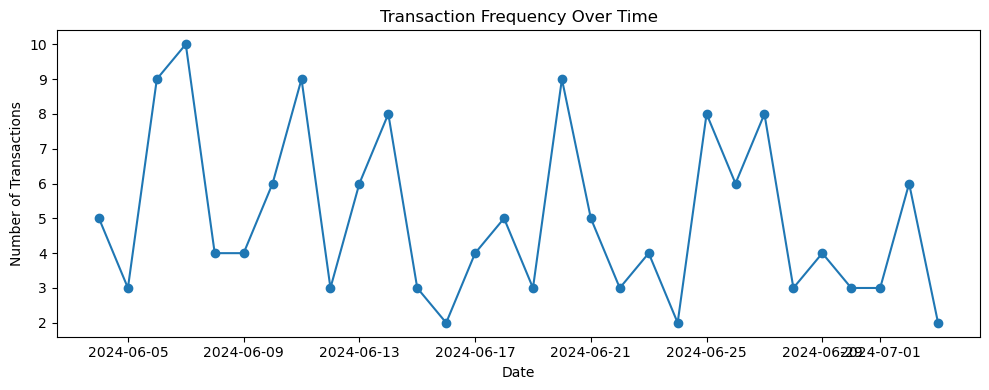

In [29]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure image directory exists
img_dir = r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\sus\image"
os.makedirs(img_dir, exist_ok=True)

# Load data and model
check_data = pd.read_csv(r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\Generate test csv\sampled_transactions.csv")
model = joblib.load(r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\bank-fraud-detection\models\best_fraud_model.pkl")

features = [
    'Amount (INR)', 'hour', 'day_of_week', 'is_weekend', 'is_large_amount',
    'same_bank_transfer', 'receiver_repeat_count', 'avg_txn_amt_sender', 'time_gap_seconds'
]

# Prepare features and predict suspicious transactions
check_data_model = check_data[features].copy().fillna(0)
for col in check_data_model.columns:
    check_data_model[col] = pd.to_numeric(check_data_model[col], errors='coerce').fillna(0)

check_data['is_suspicious'] = model.predict(check_data_model)
if check_data['is_suspicious'].min() < 0:
    check_data['is_suspicious'] = (check_data['is_suspicious'] == -1).astype(int)

fraud_check = check_data[check_data['is_suspicious'] == 1]
print(f"Suspicious transactions detected: {len(fraud_check)}")

# --- 1. Bar Chart: Total Fraud Amount by Range ---
max_amt = fraud_check['Amount (INR)'].max()
bins = [0, 100, 1000, 5000, 10000, 15000, 20000]
labels = ['<100', '100-1k', '1k-5k', '5k-10k', '10k-15k', '15k-20k', '20k+']
if max_amt > 20000:
    bins.append(max_amt + 1)
else:
    bins.append(20001)  # Ensure last bin is always greater than max_amt

fraud_check['amount_range'] = pd.cut(fraud_check['Amount (INR)'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
sns.barplot(x='amount_range', y='Amount (INR)', data=fraud_check, estimator=sum, ci=None, palette='mako')
plt.title('Total Fraud Amount by Range')
plt.xlabel('Amount Range (INR)')
plt.ylabel('Total Fraud Amount (INR)')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fraud_amount_by_range.png'))
plt.show()

# --- 2. Pie Chart: Fraud Amount by Sender Bank ---
def extract_bank(upi_id):
    try:
        bank = upi_id.split('@')[1].lower()
        if bank.startswith('ok'):
            bank = bank[2:]
        return bank
    except Exception:
        return 'unknown'

fraud_check['sender_bank'] = fraud_check['Sender UPI ID'].apply(extract_bank)
bank_sums = fraud_check.groupby('sender_bank')['Amount (INR)'].sum()
plt.figure(figsize=(6,6))
plt.pie(bank_sums, labels=bank_sums.index, autopct='%1.1f%%', startangle=140)
plt.title('Fraud Amount Distribution by Sender Bank')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fraud_amount_by_bank.png'))
plt.show()

# --- 3. Line Plot: Transaction Frequency Over Time ---
if not pd.api.types.is_datetime64_any_dtype(check_data['Timestamp']):
    check_data['Timestamp'] = pd.to_datetime(check_data['Timestamp'])

freq = check_data.groupby(check_data['Timestamp'].dt.date).size()
plt.figure(figsize=(10,4))
freq.plot(kind='line', marker='o')
plt.title('Transaction Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'transaction_frequency.png'))
plt.show()